In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from collections import OrderedDict
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

In [17]:
data = pd.read_excel('data.xlsx')

In [18]:
similarity_nlp = data[['Author Full Names','Article Title','Abstract','WoS Categories']].dropna().reset_index(drop=True)
similarity_nlp

,Author Full Names,Article Title,Abstract,WoS Categories
0,"Bai, Harrison X.; Wang, Robin; Xiong, Zeng; Hs...",Artificial Intelligence Augmentation of Radiol...,Background: Coronavirus disease 2019 (COVID-19...,"Radiology, Nuclear Medicine & Medical Imaging"
1,"Cavallo, Joseph J.; Forman, Howard P.",The Economic Impact of the COVID-19 Pandemic o...,The coronavirus 2019 (COVID-19) pandemic will ...,"Radiology, Nuclear Medicine & Medical Imaging"
2,"Hossain, Rydhwana; Lazarus, Matthew S.; Rouden...",CT Scans Obtained for Nonpulmonary Indications...,Background: Atypical manifestations of coronav...,"Radiology, Nuclear Medicine & Medical Imaging"
3,"Kim, Hyungjin; Hong, Hyunsook; Yoon, Soon Ho",Diagnostic Performance of CT and Reverse Trans...,Background: Recent studies have suggested that...,"Radiology, Nuclear Medicine & Medical Imaging"
4,"Murphy, Keelin; Smits, Henk; Knoops, Arnoud J....",COVID-19 on Chest Radiographs: A Multireader E...,Background: Chest radiography may play an impo...,"Radiology, Nuclear Medicine & Medical Imaging"
...,...,...,...,...
2595,"Tian, Yehong; Qiu, Xiaowei; Wang, Chengxiang; ...",Cancer associates with risk and severe events ...,Evidence is mounting to indicate that cancer p...,Oncology
2596,"Orlov, Marika; Wander, Pandora L.; Morrell, Er...",A Case for Targeting Th17 Cells and IL-17A in ...,"SARS-CoV-2, the virus causing COVID-19, has in...",Immunology
2597,"Alsoussi, Wafaa B.; Turner, Jackson S.; Case, ...",A Potently Neutralizing Antibody Protects Mice...,Severe acute respiratory syndrome coronavirus ...,Immunology
2598,"Ballester, Maria; Van Hoozen, Brian; Sikora, A...",Stay calm and focus on the learning outcomes: ...,Course specific learning outcomes are an impor...,"Biochemistry & Molecular Biology; Education, S..."


In [19]:
def get_full_keywords(data_selected):
    data_selected['tok_title'] = [word_tokenize(title) for title in data_selected['Article Title']]
    data_selected['tok_abstract'] = [word_tokenize(title) for title in data_selected['Abstract']]
    stop_words=set(stopwords.words("english")+list(string.punctuation)+list(string.digits))
    data_selected['text']=data_selected['tok_title']+data_selected['tok_abstract']
    
    filtered_texts=[]
    for t in data_selected['text']:
        filtered_text=[]
        for word in t:
            if word.lower() not in stop_words:
                filtered_text.append(word)
        filtered_texts.append(filtered_text)

    keywords_text = [[item.lower() for item in sublist]for sublist in filtered_texts]
    data_selected['keywords_text']=keywords_text
    data_selected['tok_text'] = [' '.join(tt for tt in ss) for ss in keywords_text] 
    data_full_test = data_selected.drop(columns=['Abstract', 'tok_title','tok_abstract','text'])
    return data_full_test

In [20]:
def keywords_ti_ab_sorted_desc(dataset):
    vocab = Counter([j for i in get_full_keywords(dataset)['keywords_text'] for j in i])
    sorted_dict = OrderedDict(sorted(vocab.items(), key = lambda kv : kv[1], reverse=True))
    kw_li = []
    for e in sorted_dict: 
        kw_li.append(e)
    return kw_li

In [13]:
def tfidf(dataset):
    vocab = keywords_ti_ab_sorted_desc(similarity_nlp)[:2000] #!!!!!!!!!!!
    vect = TfidfVectorizer(analyzer='word', ngram_range=(1,2),vocabulary=vocab)                                                                                                                                                                                                   
    tfidf = vect.fit_transform(dataset['tok_text'])                                                                                                                                                                                                                       
    columns = [k for (v, k) in sorted((v, k) for k, v in vect.vocabulary_.items())]
    tfidfs = pd.DataFrame(tfidf.todense(), columns=columns)
    
    return tfidfs

In [21]:
bow_freq_df=tfidf(get_full_keywords(similarity_nlp))

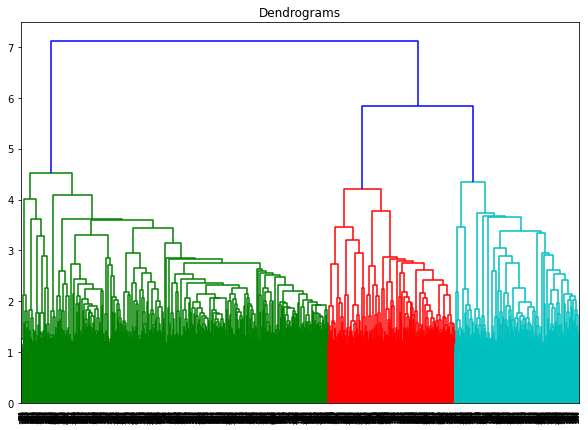

In [22]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10,7))  
plt.title('Dendrograms')  
dend = shc.dendrogram(shc.linkage(bow_freq_df, method='ward'))

In [23]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=800, affinity='euclidean', linkage='ward')
cluster_cat = cluster.fit_predict(bow_freq_df)
cluster_cat

array([459, 362, 427, ...,  82, 757, 652])

In [26]:
data_with_cluster = get_full_keywords(similarity_nlp).join(pd.DataFrame(cluster_cat, columns=['cluster']))


In [27]:
top10ppr = data[['Article Title', 'Times Cited, WoS Core','WoS Categories']].dropna().copy().sort_values('Times Cited, WoS Core', ascending=False).head(100)['Article Title']
top_cauthor_top_n_cluster = data_with_cluster.loc[data_with_cluster['Article Title'].isin(top10ppr)].reset_index(drop=True)     


In [28]:
def unique_cluster_list(dataset):
    unique_cluster=[]
    for i in range(len(dataset['cluster'])):
        for j in range(i+1,len(dataset['cluster'])):
            if dataset['cluster'][i]==dataset['cluster'][j]:
                unique_cluster.append(dataset['cluster'][i])
    return list(set(unique_cluster))           
            

In [29]:
unique_cluster_list=unique_cluster_list(top_cauthor_top_n_cluster)

In [30]:
subset_clusters = top_cauthor_top_n_cluster.loc[top_cauthor_top_n_cluster['cluster'].isin(unique_cluster_list)].sort_values('cluster').drop(
    columns=['keywords_text', 'tok_text']).reset_index(drop=True)
subset_clusters

,Author Full Names,Article Title,WoS Categories,cluster
0,"Lei, Fang; Liu, Ye-Mao; Zhou, Feng; Qin, Juan-...",Longitudinal Association Between Markers of Li...,Gastroenterology & Hepatology,1
1,"Cai, Qingxian; Huang, Deliang; Yu, Hong; Zhu, ...",COVID-19: Abnormal liver function tests,Gastroenterology & Hepatology,1
2,"Sun, Jing; Zhuang, Zhen; Zheng, Jian; Li, Kun;...",Generation of a Broadly Useful Model for COVID...,Biochemistry & Molecular Biology; Cell Biology,82
3,"Hassan, Ahmed O.; Case, James Brett; Winkler, ...",A SARS-CoV-2 Infection Model in Mice Demonstra...,Biochemistry & Molecular Biology; Cell Biology,82
4,"Wec, Anna Z.; Wrapp, Daniel; Herbert, Andrew S...",Broad neutralization of SARS-related viruses b...,Multidisciplinary Sciences,98
5,"Brouwer, Philip J. M.; Caniels, Tom G.; van de...",Potent neutralizing antibodies from COVID-19 p...,Multidisciplinary Sciences,98
6,"Bao, Rui; Zhang, Acheng",Does lockdown reduce air pollution? Evidence f...,Environmental Sciences,185
7,"Coccia, Mario",Factors determining the diffusion of COVID-19 ...,Environmental Sciences,185
8,"Randazzo, Walter; Truchado, Pilar; Cuevas-Ferr...",SARS-CoV-2 RNA in wastewater anticipated COVID...,"Engineering, Environmental; Environmental Scie...",295
9,"Kitajima, Masaaki; Ahmed, Warish; Bibby, Kyle;...",SARS-CoV-2 in wastewater: State of the knowled...,Environmental Sciences,295
